# Getting started with Amazon Braket Hybrid Jobs

This tutorial shows how to run your first Amazon Braket Hybrid Job. To get started, we consider a trivial algorithm and a small circuit with only one qubit and one gate.

This notebook to large parts follows the example `./Braket examples/hybrid_jobs/0_Creating_your_first_Hybrid_Job`. Further examples of more advanced features can be found in the directory `./Braket examples/hybrid_jobs`.

## Learning outcomes
* Write an algorithm script to run on Braket Jobs
* Understand how to run scripts or functions
* Create a job on Braket simulators or QPUs
* Monitoring the job state
* Save results from a job
* Running jobs with priority on QPUs
* Use local jobs to quickly test and debug scripts

이 결과는 X축 회전에 따라 Z 방향 스핀의 기댓값이 코사인 함수에 따라 변화함을 보여줍니다.

즉, "𝑋 회전의 각도가 변함에 따라 관측 가능한 양 𝑍의 기대값(평균값)이 어떻게 변화하는가?"

양자 컴퓨터에서 Z 연산자에 대한 기대값은 중요한 개념(양자 토모그래피)

기대값이 0이면 |0>와 |1> 상태가 균등하게 섞여 있다는 의미

기대값이 +1에 가까우면 상태가 |0>에 가깝다는 의미

기대값이 -1에 가까우면 상태가 |1>에 가깝다는 의미

## Toy Problem

Most potential candidates for quantum applications don't just run on a QPU. Instead, your workload likely shifts back and forth between a CPU/GPU and a QPU.

Let's assume a very simple toy problem to illustrate this:

<div class="alert alert-block alert-info">
    <b>How does the expectation value of the observable $Z$ change with the angle of an $X$ rotation?</b>
</div>

<div align="center">
    <img src="circuit.png" width="400" />
</div>

Obviously, this problem can be easily solved analytically. 

With $$\left|0\right> = \begin{pmatrix} 1 \\ 0 \end{pmatrix}$$ and $$R_x(\theta) = \begin{pmatrix} \cos{\frac{\theta}{2}} & -i \sin{\frac{\theta}{2}} \\ -i \sin{\frac{\theta}{2}} & \cos{\frac{\theta}{2}} \end{pmatrix}$$ the quantum state $\left|\psi\right>$ prepared by the circuit above results in $$ \left|\psi\right> = R_x(\theta) \left|0\right> = \begin{pmatrix} \cos{\frac{\theta}{2}} \\ -i \sin{\frac{\theta}{2}} \end{pmatrix} $$ With the Pauli-Z operator $$ Z = \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix} $$ the expectation value is $$ \left<\psi|Z|\psi\right> = \left|\cos{\frac{\theta}{2}}\right|^2 - \left|-i \sin{\frac{\theta}{2}}\right|^2 = \cos^2{\frac{\theta}{2}} - \sin^2{\frac{\theta}{2}} = \cos{\theta} $$

### Algorithm

For the purpose of this tutorial, we sample the result with a **hybrid algorithm** which evaluates $\left<Z\right>$ iteratively for given values of $\theta$. The classical part of the algorithm loops over the sequence of angles and updates the circuit parameter while the quantum part performs the measurement of the expecation value.

Let's review how we can code up the algorithm for this problem:

알고리즘의 고전적 컴퓨팅 영역이 일련의 각도를 반복하고 회로 파라미터를 업데이트하는 한편, 양자 컴퓨팅 영역이 기대값 측정을 수행합니다.

In [1]:
from braket.circuits import Circuit, FreeParameter, Observable
from braket.jobs.metrics import log_metric

import math


def run_algorithm(device, n_iterations, step_size, n_shots):
    # Let's define our quantum circuit
    example_circuit = Circuit().rx(0, FreeParameter("theta"))
    
    # 0번째 비트에 대한 기대값 측정
    example_circuit.expectation(observable=Observable.Z(), target=0)
    print("Quantum circuit:")
    
    #회로의 구조 출력
    print(example_circuit)

    # Here, our actual algorithm starts:
    results = {}
    for idx in range(n_iterations):
        print(f">>> Iteration {idx}")
        
        #for 문을 통해 파라미터가 업데이트 될 때마다 각도 계산은 고전 컴퓨터가 수행
        rx_angle = math.pi * idx * step_size # => 3.14*(0,1,2,..5)*0.1
    
        # 기대값은 양자 컴퓨터 사용, 100번/1000번... 측정하여 결과값 제공
        result = device.run(
            example_circuit,
            shots=n_shots,
            inputs={"theta": rx_angle}
        ).result()
        exp_val = result.values[0]

        # 각 반복에서의 회전 각도와 기대값(코사인값)을 메트릭으로 기록
        log_metric(metric_name="rotation_angle", value=rx_angle, iteration_number=idx)
        log_metric(metric_name="expectation_value", value=exp_val, iteration_number=idx)

         # 로컬 메모리에 결과 저장
        results[idx] = {
            'rx_angle': rx_angle,
            'expecation_value': exp_val
        }

    return results

Of crouse, the function `run_algorithm` can be executed locally. 

아래 코드는 일반적인 아마존 브라켓 실행 코드, 하이브리드 데코레이터(@hybrid_job)나 AwsQuantumJob 사용이 없다

즉 하이브리드 잡을 사용하지 않은 코드라서, 결과는 일반 task 형태로 구현됨

이 경우는 고전 컴퓨팅 리소스로는 로컬 환경의 고전 컴퓨팅 리소스(CPU, 메모리 등)가 사용됨

In [2]:
from braket.aws import AwsDevice
from braket.devices import Devices
from pprint import pprint

device = AwsDevice(Devices.Amazon.SV1)

#iteration이 6까지만 사용되서, 기대값이 -1까지 진입하지 못함
results = run_algorithm(device, n_iterations=6, step_size=0.1, n_shots=200)

Quantum circuit:
T  : │      0      │   Result Types   │
      ┌───────────┐ ┌────────────────┐ 
q0 : ─┤ Rx(theta) ├─┤ Expectation(Z) ├─
      └───────────┘ └────────────────┘ 
T  : │      0      │   Result Types   │

Unassigned parameters: [theta].
>>> Iteration 0
Metrics - timestamp=1734487308.398056; rotation_angle=0.0; iteration_number=0;
Metrics - timestamp=1734487308.3981674; expectation_value=1.0; iteration_number=0;
>>> Iteration 1
Metrics - timestamp=1734487311.2297387; rotation_angle=0.3141592653589793; iteration_number=1;
Metrics - timestamp=1734487311.2298682; expectation_value=0.95; iteration_number=1;
>>> Iteration 2
Metrics - timestamp=1734487315.5167563; rotation_angle=0.6283185307179586; iteration_number=2;
Metrics - timestamp=1734487315.516865; expectation_value=0.84; iteration_number=2;
>>> Iteration 3
Metrics - timestamp=1734487317.4082162; rotation_angle=0.9424777960769379; iteration_number=3;
Metrics - timestamp=1734487317.4093509; expectation_value=0.52; iteratio

In [3]:
print(results)
pprint(results)

{0: {'rx_angle': 0.0, 'expecation_value': 1.0}, 1: {'rx_angle': 0.3141592653589793, 'expecation_value': 0.95}, 2: {'rx_angle': 0.6283185307179586, 'expecation_value': 0.84}, 3: {'rx_angle': 0.9424777960769379, 'expecation_value': 0.52}, 4: {'rx_angle': 1.2566370614359172, 'expecation_value': 0.36}, 5: {'rx_angle': 1.5707963267948966, 'expecation_value': -0.07}}
{0: {'expecation_value': 1.0, 'rx_angle': 0.0},
 1: {'expecation_value': 0.95, 'rx_angle': 0.3141592653589793},
 2: {'expecation_value': 0.84, 'rx_angle': 0.6283185307179586},
 3: {'expecation_value': 0.52, 'rx_angle': 0.9424777960769379},
 4: {'expecation_value': 0.36, 'rx_angle': 1.2566370614359172},
 5: {'expecation_value': -0.07, 'rx_angle': 1.5707963267948966}}


Now, we want to explore how this can be run as an Amazon Braket Hybrid Job.

지금부터 위 코드를 하이드브리드 잡을 이용하여 구현

## The Amazon Braket Hybrid Jobs Workflow

* You can use the Amazon Braket console, a managed notebook instance, or local integrated development environment to call the Braket Hybrid Jobs API. 
* Amazon Braket Hybrid jobs starts a job instance (based on Amazon EC2) and spins up a jobs container which hosts your algorithm code. 
* In the left flow, the Jobs container then communicates with an on-demand simulator (SV1, DM1, TN1) or a QPU via a Braket API call. 
* In the right flow, the simulator is embedded directly within the Jobs container, and can be distributed across multiple CPU or GPU instances to accelerate the job. 
* Job results are stored in Amazon S3, while logs and metrics can be accessed via Amazon CloudWatch.

<div>
<img src="hybrid_jobs.png"/>
</div>

## Creating a Job

To run the algorithm defined above as a Hybrid Job, we only have to create a wrapper function which will run in the job container and prepares the inputs to the function `run_algorithm` and stores its output.

Hyperparameters can be specified as function arguments and we simply annotate the function with the [`@hybrid_job` decorator](https://aws.amazon.com/blogs/quantum-computing/explore-quantum-algorithms-faster-by-running-your-local-python-code-as-an-amazon-braket-hybrid-job-with-minimal-code-changes/) where we can specify on which device we want to execute the quantum tasks.

Then, we create a hybrid job simply by invoking the wrapper function. 

In [4]:
#hybrid_job: 하이브리드 잡을 위한 데코레이터
from braket.jobs import hybrid_job
from braket.tracking import Tracker
# 할당된 양자 디바이스 식별
from braket.jobs.environment_variables import get_job_device_arn

In [5]:
@hybrid_job(device=Devices.Amazon.SV1)
def hello_world(n_iterations, step_size, n_shots):
    print("Execution started")
    cost_tracker = Tracker().start()

    #현재 할당된 양자 디바이스를 가져옴
    device = AwsDevice(get_job_device_arn())
    results = run_algorithm(device, n_iterations, step_size, n_shots)

    cost_tracker.stop()
    print("Execution completed")
    
    #알고리즘 실행 결과, 작업 요약, 예상 비용을 포함한 딕셔너리를 반환
    return {
        "results": results,
        "task summary": cost_tracker.quantum_tasks_statistics(),
        "estimated cost": float(cost_tracker.simulator_tasks_cost() + cost_tracker.qpu_tasks_cost()),
    }

# 지금 막 정의한 hello_world 함수를 호출하여 하이브리드 작업을 시작
job = hello_world(n_iterations=11, step_size=0.1, n_shots=1000)
print(f"{job.arn} {job.state()}")

arn:aws:braket:us-east-1:122603138466:job/ddcbe388-c013-4872-940a-a66a5ad5dd1e QUEUED


## Checking the job state

The status of a Braket Job can be checked by calling `job.state()`. The state will be one of "QUEUED", "RUNNING", "FAILED", "COMPLETED", "CANCELLING", or "CANCELLED". 

In [7]:
job.state()

'COMPLETED'

## Loading the job result

Once completed, the result can be retrieved using `job.result()`. Logs and metadata are also accessible via `job.logs()` and `job.metadata()`. If you lose the reference to the job object, you can always reinstantiate it using your job ARN as `job=AwsQuantumJob("your-job-arn")`. The ARN of a job can be found in the Amazon Braket Console. By default the ARN of a job will be "`arn:aws:braket:<region>:<account_id>:job/<job_name>`". 

In [8]:
#이전에 실행한 하이브리드 작업의 결과를 가져와 출력
from pprint import pprint

result = job.result()
print(f"Create: {job.metadata()['createdAt']}")
print(f"Started: {job.metadata()['startedAt']}")
print(f"Ended: {job.metadata()['endedAt']}")
print()
print(f"Runtime of the job instance: {job.metadata()['billableDuration']} milliseconds")
print()
pprint(result['results'])

Create: 2024-12-18 02:08:58.276000+00:00
Started: 2024-12-18 02:09:50.330000+00:00
Ended: 2024-12-18 02:11:29.390000+00:00

Runtime of the job instance: 99000 milliseconds

{0: {'expecation_value': 1.0, 'rx_angle': 0.0},
 1: {'expecation_value': 0.942, 'rx_angle': 0.3141592653589793},
 2: {'expecation_value': 0.806, 'rx_angle': 0.6283185307179586},
 3: {'expecation_value': 0.62, 'rx_angle': 0.9424777960769379},
 4: {'expecation_value': 0.344, 'rx_angle': 1.2566370614359172},
 5: {'expecation_value': -0.046, 'rx_angle': 1.5707963267948966},
 6: {'expecation_value': -0.32, 'rx_angle': 1.8849555921538759},
 7: {'expecation_value': -0.588, 'rx_angle': 2.199114857512855},
 8: {'expecation_value': -0.804, 'rx_angle': 2.5132741228718345},
 9: {'expecation_value': -0.956, 'rx_angle': 2.827433388230814},
 10: {'expecation_value': -1.0, 'rx_angle': 3.141592653589793}}


In [9]:
# print(job.logs()) # uncomment to print logs

In [10]:
print("Task Summary")
print(job.result()['task summary'])
print('Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).')
print(f"Estimated cost to run tasks in this job: {job.result()['estimated cost']} USD")
print()
print(f"Billable duration of the job instance: {job.metadata()['billableDuration']} milliseconds")
#task_id = job.metadata()
#print('Task ID:', task_id)

Task Summary
{'arn:aws:braket:::device/quantum-simulator/amazon/sv1': {'shots': 11000, 'tasks': {'COMPLETED': 11}, 'execution_duration': datetime.timedelta(microseconds=32000), 'billed_execution_duration': datetime.timedelta(seconds=33)}}
Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).
Estimated cost to run tasks in this job: 0.04125 USD

Billable duration of the job instance: 99000 milliseconds


## Verify Results of our Toy Algorithm

Finally, let's verify the result of our algorithms matches our expectation:

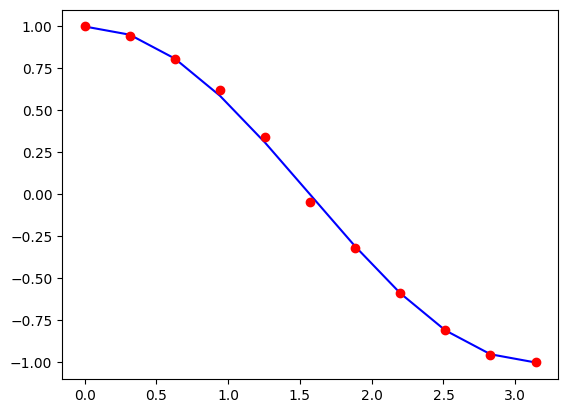

In [11]:
import matplotlib.pyplot as plt
import numpy as np

angles = [item['rx_angle'] for item in result['results'].values()]
exp_values_measured = [item['expecation_value'] for item in result['results'].values()]
exp_values_actual = np.cos(angles)

plt.plot(angles, exp_values_actual, '-', color='blue')
plt.plot(angles, exp_values_measured, 'o', color='red')
plt.draw()

'x'축은 라디언값:0~3.14

아래 'Running jobs with priority on QPUs' 은 별 내용이 없기 때문에 패스

## Running jobs with priority on QPUs

With Braket Jobs, you can run hybrid algorithms on all QPUs available through Amazon Braket. When you select a QPU as your device, your job will have priority access for the duration of your job. Quantum tasks created as part of your job will be executed ahead of other tasks in the device queue. This reduces the risk of certain tasks being delayed or drifting calibrations on the device. 

Before you create a hybrid job which runs tasks on a QPU, you can check how many quantum tasks or hybrid jobs are in front of you by checking device queue depth.

You can seamlessly swap the SV1 simulator for a QPU by changing the device argument in the decorator. 

When you create the job, Amazon Braket will wait for the QPU to become available before initializing the job. Note that the Braket Job will automatically select the AWS region where the device is available. As mentioned earlier, the specified device is provided to the job in the environment variable `AMZN_BRAKET_DEVICE_ARN`; the script `algorithm_script.py` uses this variable to choose the Braket device to use.

QPU 큐 depth를 확인해서 큐가 비어있다면, SV1에서 QPU로 바꿔서 시도할 것을 권장

In [12]:
from braket.aws import AwsDevice
from braket.devices import Devices

# This device is used for demonstration purposes only. The actual device used for our job has been specified above.
#device = AwsDevice(Devices.Rigetti.AspenM3)
device = AwsDevice("arn:aws:braket:us-west-1::device/qpu/rigetti/Ankaa-2")
print(device.queue_depth())

QueueDepthInfo(quantum_tasks={<QueueType.NORMAL: 'Normal'>: '0', <QueueType.PRIORITY: 'Priority'>: '0'}, jobs='0')


* Normal task queue depth refers to the total number of quantum tasks currently waiting to run in normal priority.
* Priority task queue depth refers to the total number of submitted quantum tasks waiting to run through Amazon Braket Hybrid Jobs. These tasks run before standalone tasks.
* Hybrid jobs queue depth refers to the total number of hybrid jobs currently queued on a device. Quantum tasks submitted as part of a hybrid job have priority, and are aggregated in the Priority Task Queue.


After you have created a hybrid job, you can track its current position within a respective device queue.

In [13]:
job.queue_position()

HybridJobQueueInfo(queue_position=None, message='Job is in COMPLETED status. AmazonBraket does not show queue position for this status.')

Jobs running task on an on-demand simulator are transitioning quickly to the `RUNNING` state. In this case, the job does not have a queue position anymore.

아래 코드는 하이브리드 양자-고전 알고리즘을 로컬에서 실행하는 예제. 
맨 위 그림의 오른쪽 환경에 있는 임베디드 시뮬레이터를 사용하는 경우 아까와는 달리, 매우 빠르게 로컬 환경에서 실행되는 것을 확인할 수 있다. 
따라서 빠른 개발과 디버깅이 필요하다면 로컬 환경 사용을 추천. 단 로컬에서 실행되었기 때문에 실행결과는 콘솔에서 확인이 불가능하다

## Debugging with local Braket Jobs

For faster testing and debugging of your code, you can run a job locally in your own environment. This feature requires Docker to be installed in your local environment. Amazon Braket notebooks have Docker pre-installed, so you can test local jobs in hosted notebooks instantly. To install Docker in your local environment, follow these [instructions](https://docs.docker.com/get-docker/). When a local job is created for the first time, it will take longer because it needs to build the container. The subsequent runs will be faster. Note that local jobs will not be visible in the Amazon Braket Console.

To run a job in local mode, make sure the Docker daemon is running, and then simply add `local=True` to the hybrid job decorator. Local jobs run synchronously and display the logs.

디버깅 등을 위해 코드를 더 빠르게 테스트 하기 위해서 로컬 환경을 사용할 수 있음

local=True 설정이 있으면 device 파라미터에 SV1이 지정되어 있더라도 임베디드 시뮬레이터가 사용됩니다.

In [14]:
@hybrid_job(device="arn:aws:braket:::device/quantum-simulator/amazon/sv1", local=True)
#@hybrid_job(device=Devices.Amazon.SV1)
def run_local_job(n_iterations, step_size, n_shots):
    print("Execution started")
    cost_tracker = Tracker().start()

    device = AwsDevice(get_job_device_arn())
    results = run_algorithm(device, n_iterations, step_size, n_shots)

    cost_tracker.stop()
    print("Execution completed")
    return {
        "results": results,
        "task summary": cost_tracker.quantum_tasks_statistics(),
        "estimated cost": float(cost_tracker.simulator_tasks_cost() + cost_tracker.qpu_tasks_cost()),
    }


local_job = run_local_job(n_iterations=11, step_size=0.1, n_shots=1000)
print(f"{local_job.arn} {local_job.state()}")

WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Pulling docker container image. This may take a while.


Login Succeeded
latest: Pulling from amazon-braket-base-jobs
7478e0ac0f23: Pulling fs layer
86b80abe5ade: Pulling fs layer
a9b5377559dc: Pulling fs layer
040e5cf49e97: Pulling fs layer
bbe7a432e446: Pulling fs layer
6aef9c98e9d4: Pulling fs layer
d55bbe965147: Pulling fs layer
bae036d63880: Pulling fs layer
397bef0299d1: Pulling fs layer
b0dc686e8660: Pulling fs layer
cadd0b99bc4e: Pulling fs layer
bef1b5126359: Pulling fs layer
fef6361aa14b: Pulling fs layer
b012b7c94064: Pulling fs layer
cbfda8be93fc: Pulling fs layer
3c1a88862043: Pulling fs layer
cadd0b99bc4e: Waiting
bef1b5126359: Waiting
fef6361aa14b: Waiting
040e5cf49e97: Waiting
b012b7c94064: Waiting
cbfda8be93fc: Waiting
3c1a88862043: Waiting
bbe7a432e446: Waiting
6aef9c98e9d4: Waiting
d55bbe965147: Waiting
bae036d63880: Waiting
397bef0299d1: Waiting
b0dc686e8660: Waiting
a9b5377559dc: Verifying Checksum
a9b5377559dc: Download complete
040e5cf49e97: Verifying Checksum
040e5cf49e97: Download complete
7478e0ac0f23: Verifying Che

Using the short-lived AWS credentials found in session. They might expire while running.


Boto3 Version:  1.35.77
Beginning Setup
Checking for Additional Requirements
Additional Requirements Check Finished
Running Code As Process
Execution started
Quantum circuit:
T  : │      0      │   Result Types   │
      ┌───────────┐ ┌────────────────┐ 
q0 : ─┤ Rx(theta) ├─┤ Expectation(Z) ├─
      └───────────┘ └────────────────┘ 
T  : │      0      │   Result Types   │

Unassigned parameters: [theta].
>>> Iteration 0
Metrics - timestamp=1734489356.326684; rotation_angle=0.0; iteration_number=0;
Metrics - timestamp=1734489356.3268178; expectation_value=1.0; iteration_number=0;
>>> Iteration 1
Metrics - timestamp=1734489359.1319983; rotation_angle=0.3141592653589793; iteration_number=1;
Metrics - timestamp=1734489359.1320438; expectation_value=0.954; iteration_number=1;
>>> Iteration 2
Metrics - timestamp=1734489362.0336435; rotation_angle=0.6283185307179586; iteration_number=2;
Metrics - timestamp=1734489362.033705; expectation_value=0.848; iteration_number=2;
>>> Iteration 3
Metrics

In [15]:
print("Task Summary")
print(local_job.result()['task summary'])
print('Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).')
print(f"Estimated cost to run tasks in this job: {job.result()['estimated cost']} USD")

#task_id = job.metadata()
job_arn = job.metadata()['jobArn']
#print('Task ID:', task_id)
print('job_arn:', job_arn)

Task Summary
{'arn:aws:braket:::device/quantum-simulator/amazon/sv1': {'shots': 11000, 'tasks': {'COMPLETED': 11}, 'execution_duration': datetime.timedelta(microseconds=225000), 'billed_execution_duration': datetime.timedelta(seconds=33)}}
Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).
Estimated cost to run tasks in this job: 0.04125 USD
job_arn: arn:aws:braket:us-east-1:122603138466:job/ddcbe388-c013-4872-940a-a66a5ad5dd1e
